# DEEP REINFORCEMENT LEARNING - MOUNTAIN CAR
In this notebook I will implement a deep reinforcement learning architecture to solve the MountainCar-v0 game, where the goal is to let the car build up enough momentum in order to reach the top of the mountain.

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import PIL.ImageOps
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from torchvision import transforms
from collections import deque
from gym import spaces

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

Definition of the virtual display.

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


## Environment
Preliminary test to understand the characterization of observation space and state space.

### Transformations

In [ ]:
def wh(img):
  img[img!=128]=0
  img[img==128]=254

  return img

Observation space dimension: 2
Action space dimension: 3


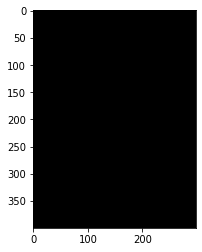

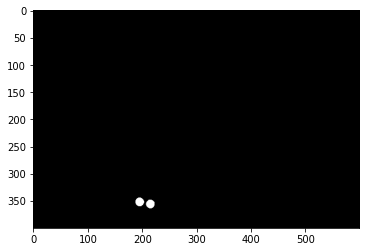

188


In [ ]:
env = gym.make("MountainCar-v0")
env.seed(0)
env.reset()

obs_space_dim = env.observation_space.shape[0]
act_space_dim = env.action_space.n

print("Observation space dimension: "+str(obs_space_dim))
print("Action space dimension: "+str(act_space_dim))

img = env.render(mode="rgb_array")
img = img[:,:,0]
img = wh(img)
idx = np.where(img==254)
rear = idx[1].min()

plt.imshow(img[:, 300:-1], cmap="gray")
plt.show()
plt.close()
plt.imshow(img, cmap="gray")
plt.show()
plt.close()
print(rear)

## Memory
Implementation of Prioritized Experience Replay memory. 

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity, alpha=0.3):
        self.memory = deque(maxlen=capacity) # Main queue 
        self.priority = deque(maxlen=capacity)
        self.alpha = alpha

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Update of main memory

        temp_prior = np.array(self.priority)
        max_prio = temp_prior.max() if temp_prior.size!=0 else 1.0

        self.priority.append(max_prio)

    def sample(self, batch_size, beta=0.4):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory

        prios = np.array(self.priority)

        probs = prios**(self.alpha)
        probs = np.array(probs, dtype="float64")
        probs /= probs.sum()

        

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]

        total = len(self.memory)
        weights = (total*(probs[indices]))**(-beta)
        weights /= weights.max()
        weights = torch.tensor(weights, dtype=torch.float32)

        batch       = list(zip(*samples))
        states      = torch.cat(tuple([s for s in batch[0]]),0)
        actions     = torch.tensor(batch[1], dtype=torch.int64)
        next_states = torch.cat(tuple([s for s in batch[2] if s is not None]),0)
        rewards     = torch.tensor(batch[3], dtype=torch.float32)
        non_final_mask = torch.tensor([s is not None for s in batch[2]], dtype=torch.bool)

        return (states, actions, next_states, rewards, non_final_mask), weights, indices 

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priority[idx] = prio

    def __len__(self):
        return len(self.memory)

Implementation of classic experience replay.

In [ ]:
class ReplayMemory2(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory

        indices = np.random.choice(len(self.memory), batch_size)
        samples = [self.memory[idx] for idx in indices]

        batch       = list(zip(*samples))
        states      = torch.cat(tuple([s for s in batch[0]]),0)
        actions     = torch.tensor(batch[1], dtype=torch.int64)
        next_states = torch.cat(tuple([s for s in batch[2] if s is not None]),0)
        rewards     = torch.tensor(batch[3], dtype=torch.float32)
        non_final_mask = torch.tensor([s is not None for s in batch[2]], dtype=torch.bool)

        return (states, actions, next_states, rewards, non_final_mask) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Policy
Implementation of both $\epsilon$-greedy policy and softmax policy.


In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('Epsilon value must be between 0 and 1')
                
    with torch.no_grad():
        net.eval()
        net_out = net(state)

    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        action = random.choice(non_optimal_actions)
    else:
        action = best_action
        
    return action, net_out.cpu()

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        #state = torch.tensor(state, dtype=torch.float32)
        state = state.to(device)
        net_out = net(state).squeeze()

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.cpu().numpy()

Definition of the exploration profile.

In [ ]:
n_iter=1000
ini_temperature=5

def explr_pr(alpha, dil):
  global n_iter, ini_temperature
  exp_decay = np.exp(-np.log(ini_temperature) / n_iter * 5)
  beta_start = 0.4

  explor_prof_greedy=[(np.exp(-alpha*i), min(1.0, beta_start + i * (1.0 - beta_start) / n_iter)) for i in range(n_iter)]
  #explor_prof_soft=[(ini_temperature*((2**((-ini_temperature*i)/n_iter))**(i*dil/n_iter)), min(1.0, beta_start + i * (1.0 - beta_start) / n_iter)) for i in range(n_iter)]
  explor_prof_soft = [(ini_temperature * (exp_decay ** i), min(1.0, beta_start + i * (1.0 - beta_start) / n_iter)) for i in range(n_iter)]
  
  return explor_prof_greedy, explor_prof_soft

## Network

In [ ]:
class DQN(nn.Module):

  def __init__(self, obs_space_dim, act_space_dim):
    super().__init__()

    self.prop = nn.Sequential(
                nn.Linear(obs_space_dim, 50),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(50, act_space_dim),
                #nn.ReLU(),
                #nn.Dropout(0.1),
                #nn.Linear(128,act_space_dim),
                #nn.ReLU()
                )

  def forward(self, x):
    x = self.prop(x)

    return x

## Initialization

In [ ]:
# Random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# PARAMETERS
gamma = 0.99   # LongTerm reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-3   # Optimizer learning rate
#weight_decay=1e-6
target_net_update_steps = 9   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = -5  # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

scores = []
trends = []

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory2(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(obs_space_dim, act_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(obs_space_dim, act_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

policy_net.to(device)
target_net.to(device)

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()
loss_fn_batch = nn.SmoothL1Loss(reduction="none")        # PER

## Training


In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, beta):

    # For PER, initialize ReplayMemory instead of ReplayMemory2

    # Sample the data from the replay memory
    #batch, wt, indices = replay_mem.sample(batch_size, beta)                    # PER
    #wt = wt.unsqueeze(dim=1).to(device)                                         # PER
    batch = replay_mem.sample(batch_size)                                      # Simple ER
    batch_size = len(batch[0])                                                  
    
    
    # Create tensors for each element of the batch
    states = batch[0].to(device)                                                                                              
    actions = batch[1].to(device)                                                                                             
    rewards = batch[3].to(device)                                                                                             

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = batch[2].to(device)                                                         
    non_final_mask = batch[4].to(device)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(dim=1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states.squeeze())
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    #batch_loss = torch.mul((state_action_values-expected_state_action_values)**(2),wt)                                        # PER
    #prios = batch_loss.detach().cpu().numpy() + 1e-5                                                                          # PER

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    #replay_mem.update_priorities(indices, prios)                                                                               # PER
    optimizer.step()

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
action_space_dim=env.action_space.n
env.seed(0) # Set a random seed for the environment (reproducible results)
# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 20 == 0) # Save a video every 100 episodes

Models = []
# Definition of the values for dilation factors
alpha=[0.01, 0.02, 0.05, 0.1, 0.5]
dil=[25, 50, 75, 100, 125]
pol="greedy"
vel = []

for j in range(1):
  explor_prof_greedy, explor_prof_soft = explr_pr(alpha[j],dil[j])
  if pol=="soft":
    exploration_profile = explor_prof_soft
  elif pol=="greedy":
    exploration_profile = explor_prof_greedy
  for episode_num, (tau, b) in enumerate(tqdm(exploration_profile)):

      # Reset the environment and get the initial state
      state = env.reset()

      img = env.render(mode="rgb_array")
      img = img[:,:,0]
      img = wh(img)
      idx = np.where(img==254)
      start_rear = idx[1].min()

      state = torch.tensor(state, dtype=torch.float32).unsqueeze(dim=0).to(device)
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False

      # Go on until the pole falls off
      while not done:
        
        # Choose the action following the policy
        if pol=="soft":
          action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
        elif pol=="greedy":
          action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
      
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        img = img[:,:,0]
        img = wh(img)
        idx = np.where(img==254)
        rear = idx[1].min()
        flag = np.mean(img[:,300:-1])

        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(dim=0).to(device)
        vel.append(state[0][1])

        #vel_weight = 100
        #ds_weigth = 0.001
        reward = (rear-start_rear)*next_state[0][1]#reward #+ (rear/600)*(flag/255) #ds_weigth * rear - (vel_weight-(next_state[0][0]*vel_weight)/0.5) * next_state[0][1]  # 0.5 is the height for the top of the Mountain

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the cart is in the valley
            reward += bad_state_penalty
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, b)

        # Set the current state for the next iteration
        state = next_state

      scores.append(score)
      trends.append(sum(scores[-30:])/min(len(scores),30))
      # Update the target network every target_net_update_steps episodes
      if episode_num % target_net_update_steps == 0:
          print('Updating target network...')
          target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      # Print the final score
      if pol=="soft":
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}")
      elif pol=="greedy":
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Epsilon: {tau}")
    
      # Early Stop Condition
      early_stop=0
      if episode_num>50:
        early_stop=np.mean(scores[-10:])
      if episode_num==(n_iter-1) or early_stop<105:
        model={"policy":pol, "episode":episode_num, "alpha":alpha[j], "dil":dil[j]}
        Models.append(model)
        name="Policy_param_"+pol+"_"+str(j)+".pth"
        torch.save(policy_net.state_dict(),name)
      if episode_num>50:
        if early_stop>450:
            break

  print("---------------------------------------------------------")
  print()
  print("---------------------------------------------------------")

env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 200 - Epsilon: 1.0
EPISODE: 2 - FINAL SCORE: 200 - Epsilon: 0.9900498337491681
EPISODE: 3 - FINAL SCORE: 200 - Epsilon: 0.9801986733067553
EPISODE: 4 - FINAL SCORE: 200 - Epsilon: 0.9704455335485082
EPISODE: 5 - FINAL SCORE: 200 - Epsilon: 0.9607894391523232
EPISODE: 6 - FINAL SCORE: 200 - Epsilon: 0.951229424500714
EPISODE: 7 - FINAL SCORE: 200 - Epsilon: 0.9417645335842487
EPISODE: 8 - FINAL SCORE: 200 - Epsilon: 0.9323938199059483
EPISODE: 9 - FINAL SCORE: 200 - Epsilon: 0.9231163463866358
Updating target network...
EPISODE: 10 - FINAL SCORE: 200 - Epsilon: 0.9139311852712282
EPISODE: 11 - FINAL SCORE: 200 - Epsilon: 0.9048374180359595
EPISODE: 12 - FINAL SCORE: 200 - Epsilon: 0.8958341352965282
EPISODE: 13 - FINAL SCORE: 200 - Epsilon: 0.8869204367171575
EPISODE: 14 - FINAL SCORE: 200 - Epsilon: 0.8780954309205613
EPISODE: 15 - FINAL SCORE: 200 - Epsilon: 0.8693582353988059
EPISODE: 16 - FINAL SCORE: 200 - Epsilon: 0.860707976425

In [ ]:
print(max(vel))

tensor(0.0624, device='cuda:0')


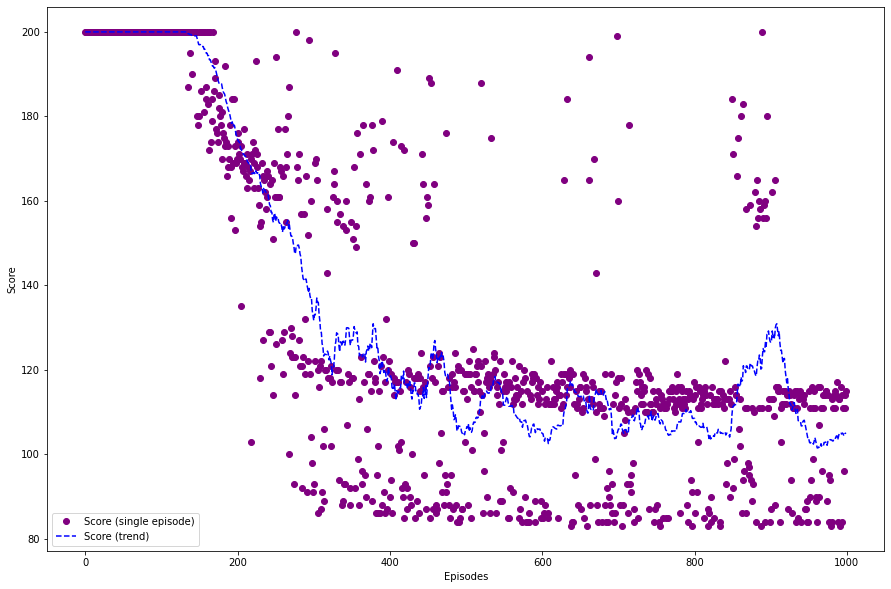

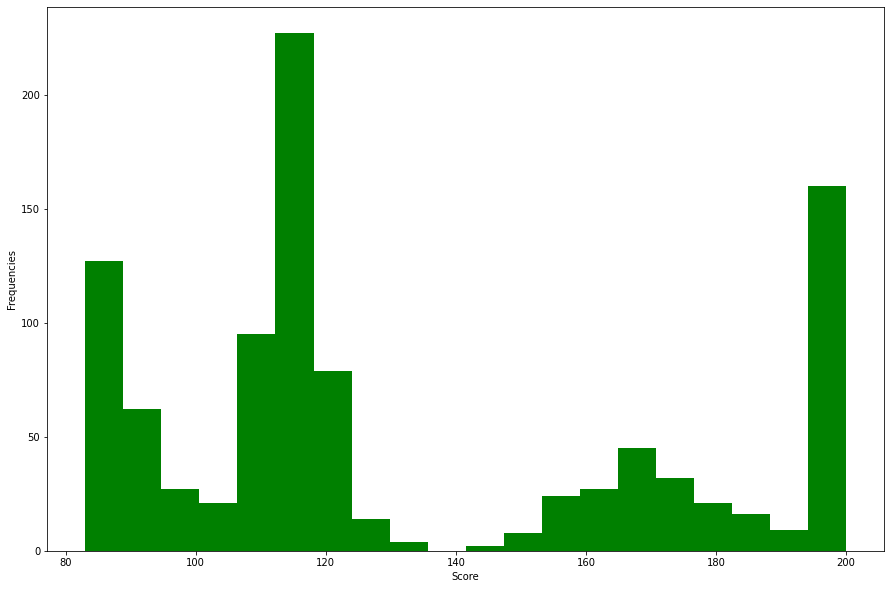

In [ ]:
ax = range(len(scores))
plt.figure(figsize=(15,10))
plt.plot(ax, scores, marker="o", color="purple", linestyle="", label="Score (single episode)")
plt.plot(ax, trends, linestyle="dashed", color="blue", label="Score (trend)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(15,10))
plt.hist(scores, bins=20, color="green")
plt.xlabel("Score")
plt.ylabel("Frequencies")
plt.show()

## Testing

EPISODE 1 - FINAL SCORE: -89.0
EPISODE 2 - FINAL SCORE: -113.0
EPISODE 3 - FINAL SCORE: -112.0
EPISODE 4 - FINAL SCORE: -112.0
EPISODE 5 - FINAL SCORE: -90.0
EPISODE 6 - FINAL SCORE: -111.0
EPISODE 7 - FINAL SCORE: -111.0
EPISODE 8 - FINAL SCORE: -113.0
EPISODE 9 - FINAL SCORE: -97.0
EPISODE 10 - FINAL SCORE: -113.0
----------------------------------------------------------

----------------------------------------------------------
{'policy': 'greedy', 'episode': 0, 'alpha': 0.01, 'dil': 25}
FINAL MEAN SCORE: -106.1


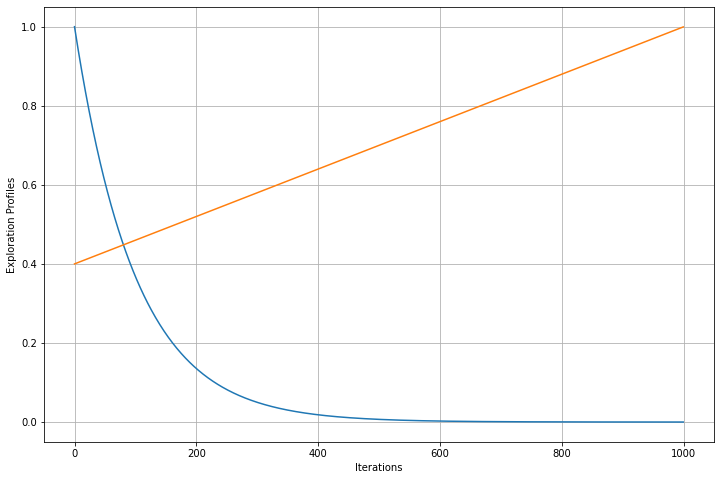

----------------------------------------------------------

----------------------------------------------------------


In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

mean_scores=[]

# Let's try for a total of 10 episodes
for j in range(1):
  policy_net=DQN(obs_space_dim, act_space_dim)
  name="Policy_param_"+pol+"_"+str(j)+".pth"
  policy_net.load_state_dict(torch.load(name))
  score_m=[]
  policy_net.to(device)
  for num_episode in range(10): 
      # Reset the environment and get the initial state
      state = env.reset()
      state = torch.tensor(state, dtype=torch.float32).unsqueeze(dim=0).to(device)
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False
      # Go on until the pole falls off or the score reach 490
      while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(dim=0).to(device)
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
      # Print the final score
      score_m.append(score)
      print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
      if num_episode==9:
        mean_scores.append(np.mean(score_m))
  print("----------------------------------------------------------")
  print()
  print("----------------------------------------------------------")
env.close()

for j in range(1):
  print(Models[j])
  print("FINAL MEAN SCORE: "+str(mean_scores[j]))
  explor_prof_greedy, explor_prof_soft = explr_pr(alpha[j],dil[j])

  plt.figure(figsize=(12,8))
  if pol=="greedy":
    plt.plot(explor_prof_greedy)
  elif pol=="soft":
    plt.plot(explor_prof_soft)
  plt.grid()
  plt.xlabel("Iterations")
  plt.ylabel("Exploration Profiles")
  plt.show()

  print("----------------------------------------------------------")
  print()
  print("----------------------------------------------------------")